## Проект: телекоммуникации

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, оператору нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

Описание услуг
Оператор предоставляет два основных типа услуг: 

    Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
    Интернет. Подключение может быть двух типов: через телефонную линию или оптоволоконный кабель.

Также доступны такие услуги:

    Интернет-безопасность: антивирус и блокировка небезопасных сайтов;
    Выделенная линия технической поддержки;
    Облачное хранилище файлов для резервного копирования данных;
    Стриминговое телевидение и каталог фильмов.

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.


##  План работы

1. Загрузка данных Загрузите данные и выполните их первичный осмотр.
    - считаем файлы и посморим на пропуски, явные дубли и типы данных; 
    - посчитаем пользователей, которые пользуются и интернетом и телефоном или только чем-то одним; 
    - делаем промежуточный вывод 
2. Исследовательский анализ данных и предобработка
    - для каждого признака смотрим на наличие пропусков;
    - изменяем тип  данных для тех признаков, к которым на данном этапе необходимо применить эту процедуру;
    - для каждого числовго признака строим гистограмму и комментируем замеченные особенности;
    - для категориальных признаков:
        - value_counts;
        - строим гистограмму (горизонтальную) 
        - или пирог с распределением числа значений категории - если считаем нужным;
        - комментируем;
    - если это возможно, отмечаем те признаки, которые будут переданы модели машинного обучения.
3. Объединяем данные в один датафрейм
    - объединяем
    - обрабатываем пропуски
4. Исследовательский анализ в объединенном датафрейме
    - смотрим на признаки из personal, internet и phone сравнивая их распределение в группах дейсвющих и ушедших пользователей
    - отбираем признаки для модели
5. формируем **features** и **target**
    - формируем
    - анализ корреляций
    - окончательный выбор
6. делим данные на обучающую и тестовую выборки
7. Обучение моделей
    - всего обучим 3 модели
        - LogisticRegression
        - RandomForestClassifier
        - CatBoostClassifier
    - для каждой надем оптимальные гиперпараметры
    - метрика качества модели **AUC-ROC** >= 0.85
    - выбираем лучшую модель и тестируем ее на тестовой выборке
8. Компиллируем обыщий вывод (отчет)

## imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [3]:
from catboost import CatBoostClassifier

In [4]:
import phik

In [5]:
RANDOM_STATE=80424

## Functions

In [6]:
# функция возвращающая число категорий для категориального признака

def type_counts(series):
    return len(series.unique())

In [7]:
# функция для рисовки пирога с распределением значений катеориального признака

def pie(series, title=''):
    ax = series.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10), legend=True)
    if title == '':
        ax.set_title(f'Диаграма пирог для призака {series.name}')
    else:
        ax.set_title(title)

In [8]:
# функция для рисовки гистограмм

def hist(series, bins=10, title=''):
    ax = series.hist(bins=bins, figsize=(10, 10))
    if title == '':
        ax.set_title(f'Гистограмма для признака {series.name}')
    else:
        ax.set_title(title)
    
    ax.set_xlabel(series.name)
    ax.set_ylabel('counts')

In [9]:
# функция для анализа категориального признака в разных группах: дейвующих пользователей и ушедших
# показывает как распределены частоты значений в разных группах

def compare(df, series_name):
    if series_name in df:
        if 'EndDate' in df:
            print('Распределение занчений в общем:')
            print(df[series_name].value_counts(normalize=True))
            
            print()
            
            print('Распрделение значений в группе дейсвующих пользователей:')
            cut = df['EndDate'] == '2020-02-01'
            print(df[cut][series_name].value_counts(normalize=True))
            
            print()
            
            print('Распрделение значений в группе ушедших пользователей:')
            print(df[~cut][series_name].value_counts(normalize=True))
        else:
            print('сравнение невозможно: датафрейм не содержит признака EndDate')       
    else:
        print('сравнение невозможно: датафрейм не содержит признака ', series_name)

In [10]:
# Функция для построения ROC кривой
# Рисует roc-кривую и ничего не возвращает

def draw_roc_curve(target, probabilities, title='ROC-кривая'):

    fpr, tpr, thrd = roc_curve(
        target, probabilities)

    # ROC-кривая случайной модели (выглядит как прямая)
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.plot(fpr, tpr)
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True);

## Загрузка данных и первичный осмотр

### Информация о договоре

In [11]:
contract_df = pd.read_csv('contract_new.csv')

In [12]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [13]:
contract_df.duplicated().sum()

0

In [14]:
contract_df.sample(n=5, random_state=RANDOM_STATE)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
15,3655-SNQYZ,2014-05-01,2016-03-01,Two year,No,Credit card (automatic),113.25,2491.5
1329,3910-MRQOY,2014-02-01,No,Two year,No,Bank transfer (automatic),19.40,1536.48
52,6575-SUVOI,2018-01-01,No,Month-to-month,Yes,Credit card (automatic),69.50,1807.0
2957,2674-MIAHT,2019-10-01,No,Month-to-month,Yes,Mailed check,80.30,343.68
1362,2568-BRGYX,2019-07-01,No,Month-to-month,Yes,Electronic check,70.20,515.97


Данные без явных пропусков. 

Требуется преобразование типов для:
- `TotalCharges` -> float
- `EndDate` и `BeginDate` -> datetime, для `EndDate` значения "No" заменим на 2020-02-01 - момент актуализации данных. 

### Персональные данные клиента

In [15]:
personal_df = pd.read_csv('personal_new.csv')

In [16]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [17]:
personal_df.duplicated().sum()

0

In [18]:
personal_df.sample(n=5, random_state=RANDOM_STATE)

,customerID,gender,SeniorCitizen,Partner,Dependents
15,3655-SNQYZ,Female,0,Yes,Yes
1329,3910-MRQOY,Female,0,Yes,No
52,6575-SUVOI,Female,1,Yes,No
2957,2674-MIAHT,Female,0,No,No
1362,2568-BRGYX,Male,0,No,No


Данные без пропусков. Пока, пока преобразование типов не требуется.

### Информация об интернет-услугах

In [19]:
internet_df = pd.read_csv('internet_new.csv')

In [20]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [21]:
internet_df.duplicated().sum()

0

In [22]:
internet_df.sample(n=5, random_state=RANDOM_STATE)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4851,1599-MMYRQ,Fiber optic,Yes,Yes,No,No,No,No
1894,7389-KBFIT,DSL,No,Yes,No,No,No,No
3276,0495-ZBNGW,Fiber optic,No,No,Yes,No,No,No
1428,2070-XYMFH,Fiber optic,No,No,Yes,No,No,No
4078,5376-PCKNB,Fiber optic,No,Yes,Yes,No,Yes,Yes


### Информация об услугах телефонии

In [23]:
phone_df = pd.read_csv('phone_new.csv')

In [24]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [25]:
phone_df.duplicated().sum()

0

In [26]:
CLIENTS_NUMBER = internet_df.merge(phone_df, on='customerID', how='outer')['customerID'].count()
CLIENTS_NUMBER

7043

In [27]:
INTERNET_AND_PHONE_CLIENTS_NUMBER = internet_df.merge(phone_df, on='customerID', how='inner')['customerID'].count()
INTERNET_AND_PHONE_CLIENTS_NUMBER

4835

In [28]:
ONLY_INTERNET_CLIENTS_NUMBER = internet_df['customerID'].count() - INTERNET_AND_PHONE_CLIENTS_NUMBER
ONLY_INTERNET_CLIENTS_NUMBER

682

In [29]:
ONLY_PHONE_CLIENTS_NUMBER = phone_df['customerID'].count() - INTERNET_AND_PHONE_CLIENTS_NUMBER
ONLY_PHONE_CLIENTS_NUMBER

1526

In [30]:
INTERNET_AND_PHONE_CLIENTS_NUMBER + ONLY_INTERNET_CLIENTS_NUMBER + ONLY_PHONE_CLIENTS_NUMBER

7043

### Вывод: Загрузка данных и первичный осмотр

Данные содержать информацию о **7043** пользователях.Из них пользуются:
- интернетом и телефоном **4835**
- только интеретом **682**
- только телефоном **1526**

Данные не содержат явных пропусков и дубликатов. 

Требуется преобразование типов для признаков:
- `TotalCharges` -> float
- `EndDate` и `BeginDate` -> datetime, для `EndDate` значения "No" заменим на 2020-02-01 - момент актуализации данных.

Преобразование будет осущесвленно ниже, в соотвесвующем подпункте.

## Исследовательский анализ и предобработка данных 

### Информация о договоре

#### `customerID`

In [31]:
contract_df['customerID'].isna().sum()

0

In [32]:
len(contract_df['customerID'].unique()) == contract_df['customerID'].count()

True

In [33]:
contract_df['customerID'].head()

0    7590-VHVEG
1    5575-GNVDE
2    3668-QPYBK
3    7795-CFOCW
4    9237-HQITU
Name: customerID, dtype: object

In [34]:
contract_df['customerID'].str.contains('^\d{4}-[A-Z]{5,5}').sum() == contract_df['customerID'].count()

True

Все `customerID` - уникальны. Все соотвесуют шаблону: 4 цифры - 5 англ. символов в верхнем регистре. 
Не будет оспользован для предсказания т.к. уникальнен для каждого пользователя и не несет в себе информации о его поведении. 

#### `BeginDate`

In [35]:
contract_df['BeginDate'].isna().sum()

0

In [36]:
contract_df['BeginDate'].head()

0    2020-01-01
1    2017-04-01
2    2019-10-01
3    2016-05-01
4    2019-09-01
Name: BeginDate, dtype: object

In [37]:
contract_df['BeginDate'].str.contains('^\d{4}-\d{2}-\d{2}').sum()

7043

In [38]:
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d')

In [39]:
contract_df['BeginDate'].head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: BeginDate, dtype: datetime64[ns]

`BeginDate` не содержит пропусков. Данные приведены к типу datetime в вормате **Y-m-d (год-месяц-день)**. Данный признак кандидат на передачу будущей модели т.к. от него может зависеть предсказание, например подключения интернета в сентябре могут пргнозировать отключения интернета в июне.. клиенты в этом случае студенты. 

#### `EndDate`

In [40]:
contract_df['EndDate'].isna().sum()

0

In [41]:
contract_df['EndDate'].str.contains('^\d{4}-\d{2}-\d{2}').sum()

1101

In [42]:
contract_df[~contract_df['EndDate'].str.contains('^\d{4}-\d{2}-\d{2}')]['EndDate'].value_counts()

No    5942
Name: EndDate, dtype: int64

In [43]:
contract_df[contract_df['EndDate'] == '2020-02-01']['EndDate'].sum()

0

In [44]:
contract_df.loc[contract_df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

In [45]:
contract_df['EndDate'].str.contains('^\d{4}-\d{2}-\d{2}').sum() == contract_df['EndDate'].count()

True

In [46]:
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], format='%Y-%m-%d')

In [47]:
contract_df['EndDate'].head()

0   2020-02-01
1   2020-02-01
2   2020-02-01
3   2020-02-01
4   2020-02-01
Name: EndDate, dtype: datetime64[ns]

`EndDate` не содержит пропусков. Значения "No" заменены на дату 2020-02-01. 
Значения признака приведены к типу datetime. Данный признак не будет передоваться модели т.к. будет прямая утечка данных. Из этого признака мы позже сформируем таргет! 

#### `Type`

In [48]:
contract_df['Type'].isna().sum()

0

In [49]:
contract_df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

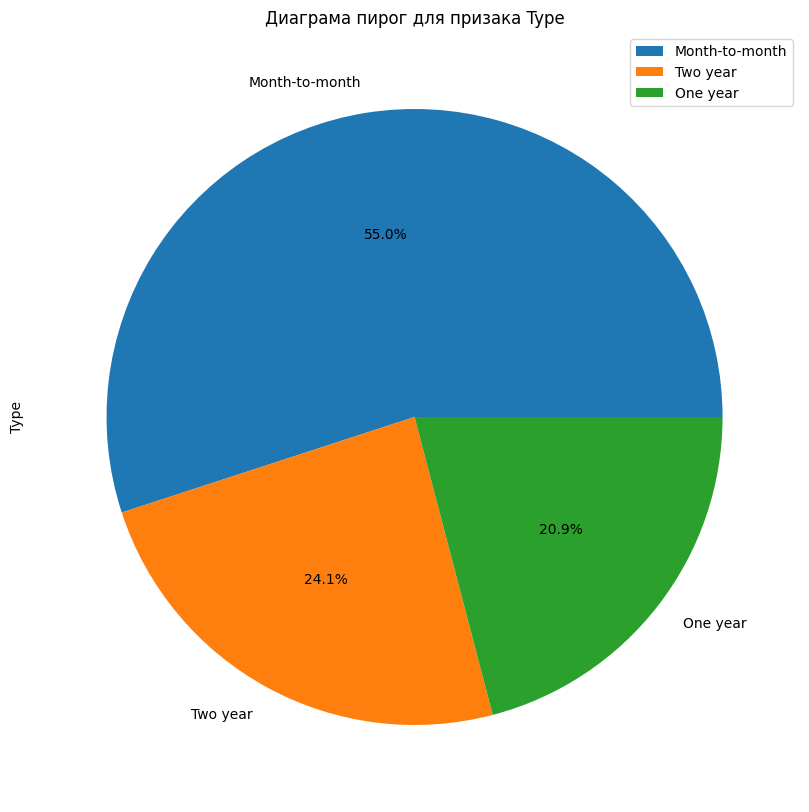

In [50]:
pie(contract_df['Type'])

`Type` не содержит пропусков. Больше половины пользователей платять ежемесячно, а раз в год или два - примерно одинаково. Данный признак кандидат для модели т.к. характеризует пользователя. 

#### `PaperlessBilling`

In [51]:
contract_df['PaperlessBilling'].isna().sum()

0

In [52]:
contract_df['PaperlessBilling'].value_counts(normalize=True)

Yes    0.592219
No     0.407781
Name: PaperlessBilling, dtype: float64

In [53]:
contract_df[contract_df['EndDate'] == '2020-02-01']['PaperlessBilling'].value_counts(normalize=True)

Yes    0.580613
No     0.419387
Name: PaperlessBilling, dtype: float64

In [54]:
contract_df[~(contract_df['EndDate'] == '2020-02-01')]['PaperlessBilling'].value_counts(normalize=True)

Yes    0.654859
No     0.345141
Name: PaperlessBilling, dtype: float64

`PaperlessBilling` не содержит пропусков. Значения распределыены 60 на 40 процетов. Среди тех кто разорвал договор - соотношение то же 60 на 40 процентов, а среди тех кто нет - 65 на 35 процентов. Так как у нас маленькая выборка, то отличие в 5 процентов можно считать несущесвенным. Следовательно, данный признак рапределен случайным образом и вероятно не характеризует поьзователя. 

#### `PaymentMethod`

In [55]:
contract_df['PaymentMethod'].isna().sum()

0

In [56]:
contract_df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

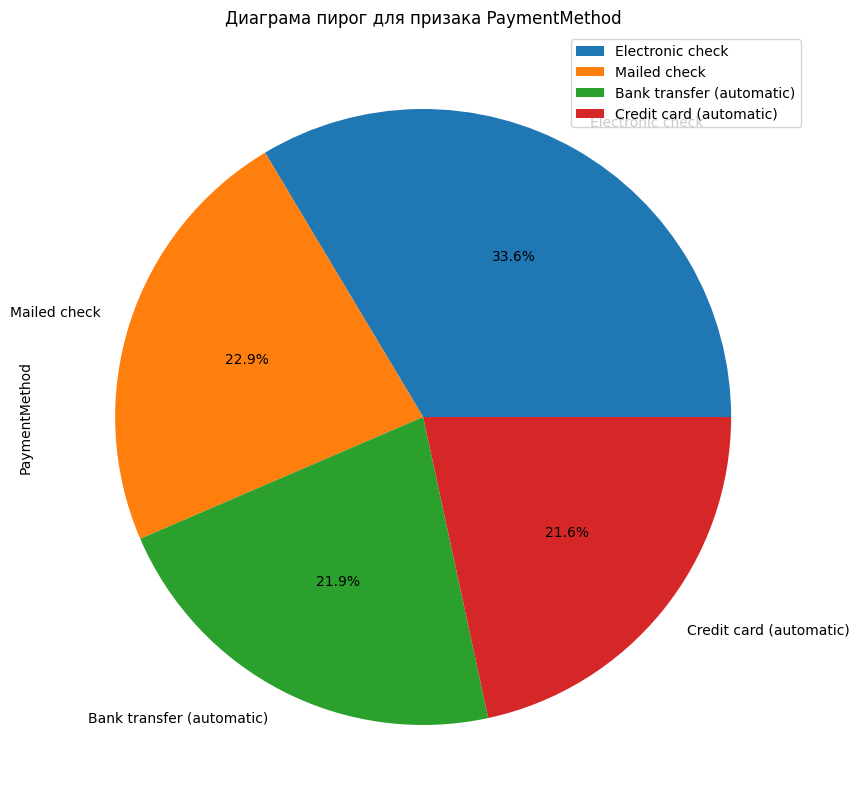

In [57]:
pie(contract_df['PaymentMethod'])

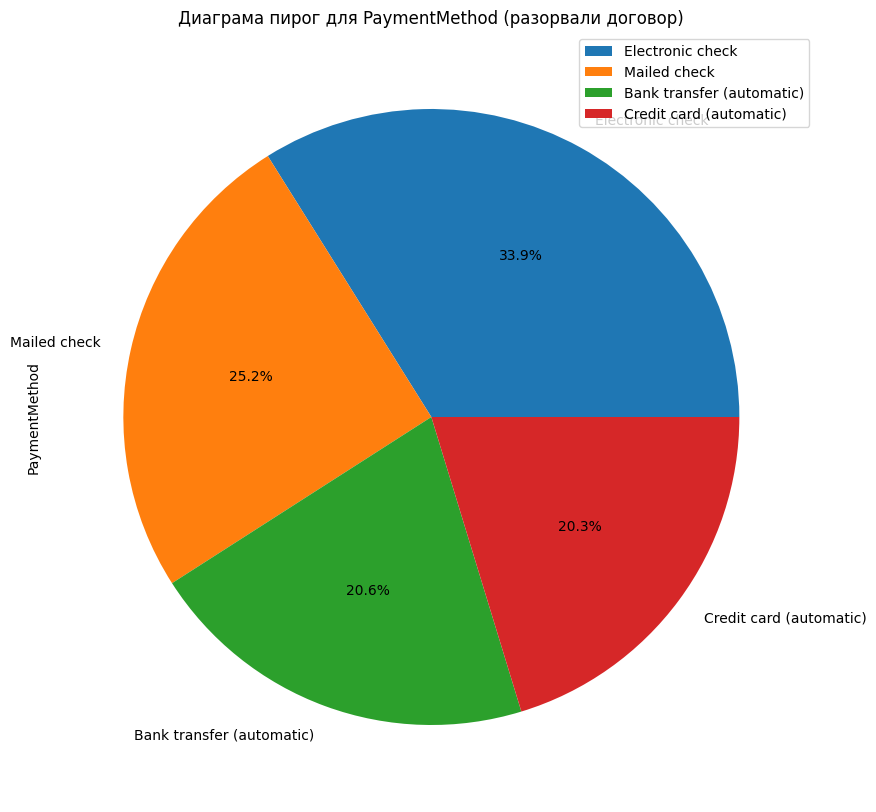

In [58]:
pie(contract_df[contract_df['EndDate'] == '2020-02-01']['PaymentMethod'],
    title='Диаграма пирог для PaymentMethod (разорвали договор)')

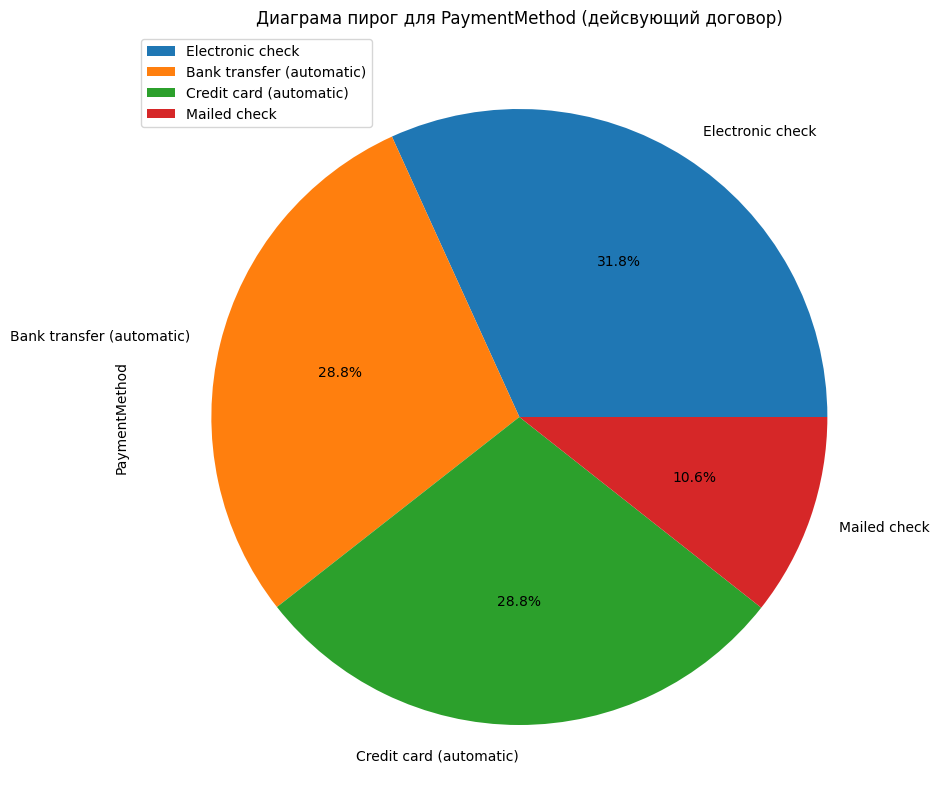

In [59]:
pie(contract_df[~(contract_df['EndDate'] == '2020-02-01')]['PaymentMethod'],
    title='Диаграма пирог для PaymentMethod (дейсвующий договор)')

`PaymentMethod` не содержит пропусков. Больше всего пользоваелей вкатегории `Electronic check` 34%, в остальных примерно одинаково. Автоматические платежи и нет - распределены примерно поровну. Сравнивая пользователей с дейсвующим и разорваным договорами - получили сущевенную разницу в распределениях значений: 
- для растогнутого договора соотношения следующие:
    - Electrinic check 34%
    - Mailed check 25%
    - Banck trasfer (auto) 21%
    - Credit card (auto) 20%
- для дейсвующего договора соотношения следующие:
    - Electrinic check 32%
    - Mailed check 10%
    - Banck trasfer (auto) 29%
    - Credit card (auto) 29%

Данный признак показывает разницу между интересующими нас группами - в кандидаты его!

#### `MonthlyCharges`

In [60]:
contract_df['MonthlyCharges'].isna().sum()

0

In [61]:
contract_df['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

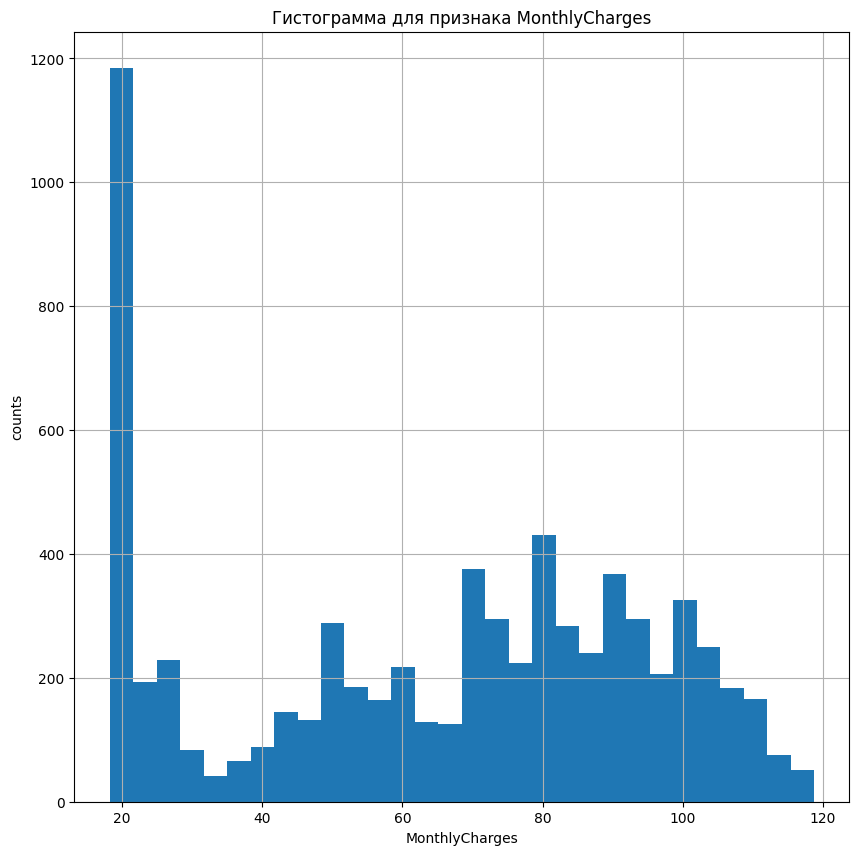

In [62]:
hist(contract_df['MonthlyCharges'] ,bins=30)

`MonthlyCharges` не содержит пропуски. Значения лежат в итервале **[18:119]**. Распределение значений - больше всего около минимума, остальные распределены гребенкой. Хороший кандидат, но посморим на следующий признак `TotalCharges` и выберем один из них т.к. вероятно они сильно скорелированы. 

#### `TotalCharges`

In [63]:
contract_df['TotalCharges'].isna().sum()

0

Вспоминам, что тут нам нужно изменить тип данных! 

In [64]:
try:
    contract_df['TotalCharges'].astype('float')
except:
    print('Не все так просто!')

Не все так просто!


Получили ошибку! Скорее всего не все значения соответвуют шаблону записи числа с плавающей точкой! Посмортрим, что это за значения и посчитаем сколько их!

In [65]:
contract_df[~contract_df['TotalCharges'].str.contains('^[0-9]*[.,]?[0-9]+$')]['TotalCharges'].value_counts()

     11
Name: TotalCharges, dtype: int64

11 пустых строк! Посмострим на пользователей с данными пропусками!

In [66]:
contract_df[contract_df['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,


Все пользователи с пропуском в `TotalCharges` заключили договор га 2 года и договор заключен имеенно в день скачивания данных. Посмортрим на примеры тех, кто заключил контракт на 2 года, но не имеет пропуска. 

In [67]:
contract_df[(contract_df['Type'] == 'Two year') & (contract_df['TotalCharges'] != ' ')].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
11,7469-LKBCI,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,312.3
15,3655-SNQYZ,2014-05-01,2016-03-01,Two year,No,Credit card (automatic),113.25,2491.5
17,9959-WOFKT,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),106.70,8257.51
23,3638-WEABW,2015-04-01,2020-02-01,Two year,Yes,Credit card (automatic),59.90,3821.62
28,5248-YGIJN,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),90.25,6498.0


Возьмем 15 строку. С 2014-05-01 по 2016-03-01 прошло 22 месяца.

In [68]:
2491.5 / 22

113.25

Что совпадает с месячными затратами! Проверим для всех ли данных выполняется это условие. Для этого умножим месячные расходы на число месяцев и отнимем это значение от `TotalCharges` - построим распределение!

In [69]:
contract_df_mem = contract_df.copy()

In [70]:
contract_df = contract_df[contract_df['TotalCharges'] != ' ']

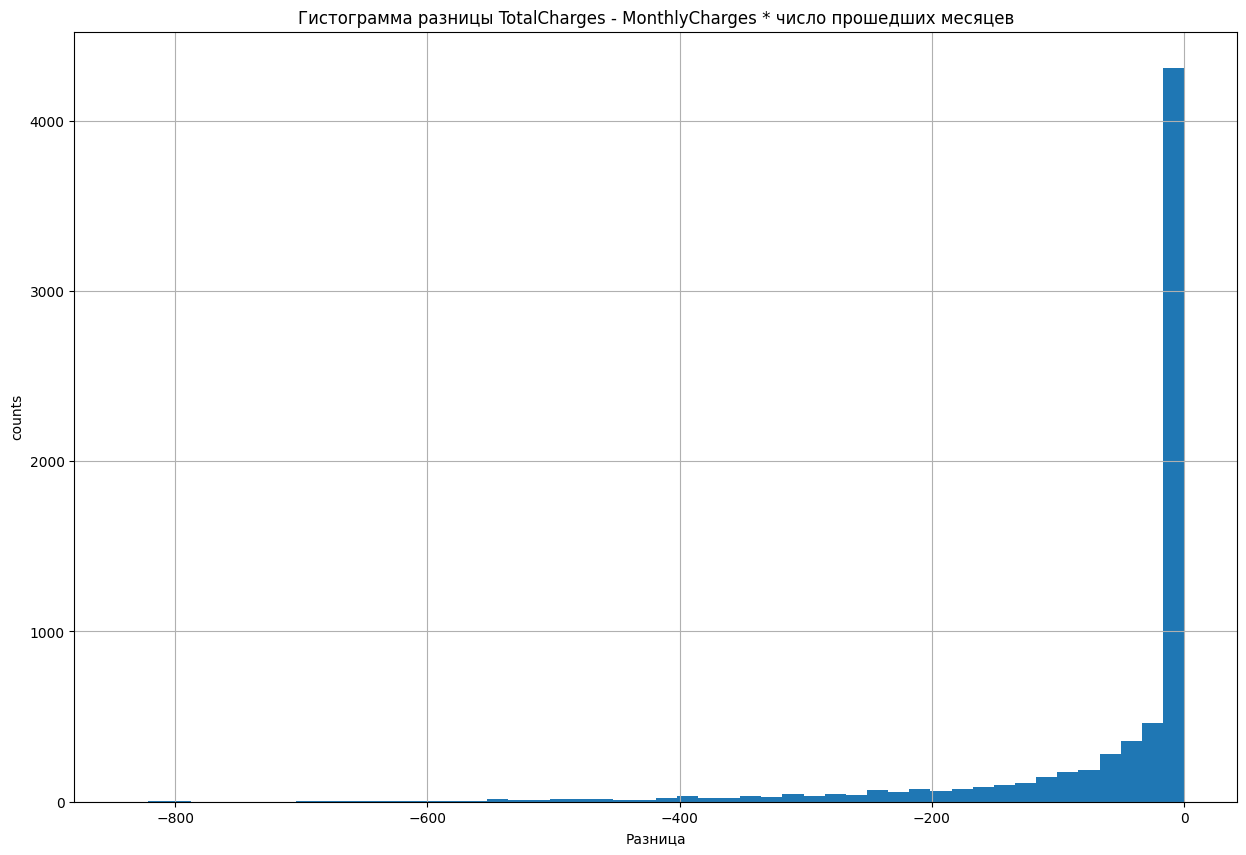

In [71]:
ax = (
  ( (12 * (contract_df['EndDate'].dt.year - contract_df['BeginDate'].dt.year) +  
      contract_df['EndDate'].dt.month - contract_df['BeginDate'].dt.month) *
    contract_df['MonthlyCharges']
  ) -
  contract_df['TotalCharges'].astype('float')
).hist(bins=50, figsize=(15, 10))

ax.set_title('Гистограмма разницы TotalCharges - MonthlyCharges * число прошедших месяцев')
ax.set_xlabel('Разница')
ax.set_ylabel('counts');

Получили распределенение где большество значений равно нулю. На данном этапе не будем подробно разбираться откуда такие большие ращницы, по всей видимости это связано с алгоритмом расчета. 

11 пользователей не так много. Удалим их из выборки т.к. это пользователи которые только пришли - они бесполезны для модели, но запомним их `cutomerID` на будущее.

In [72]:
mem_cutomer_id_with_empty_total_charges = contract_df_mem[contract_df_mem['TotalCharges'] == ' ']['customerID'].copy()

In [73]:
del contract_df_mem

In [74]:
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype('float')

In [75]:
contract_df['TotalCharges'].describe()

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64

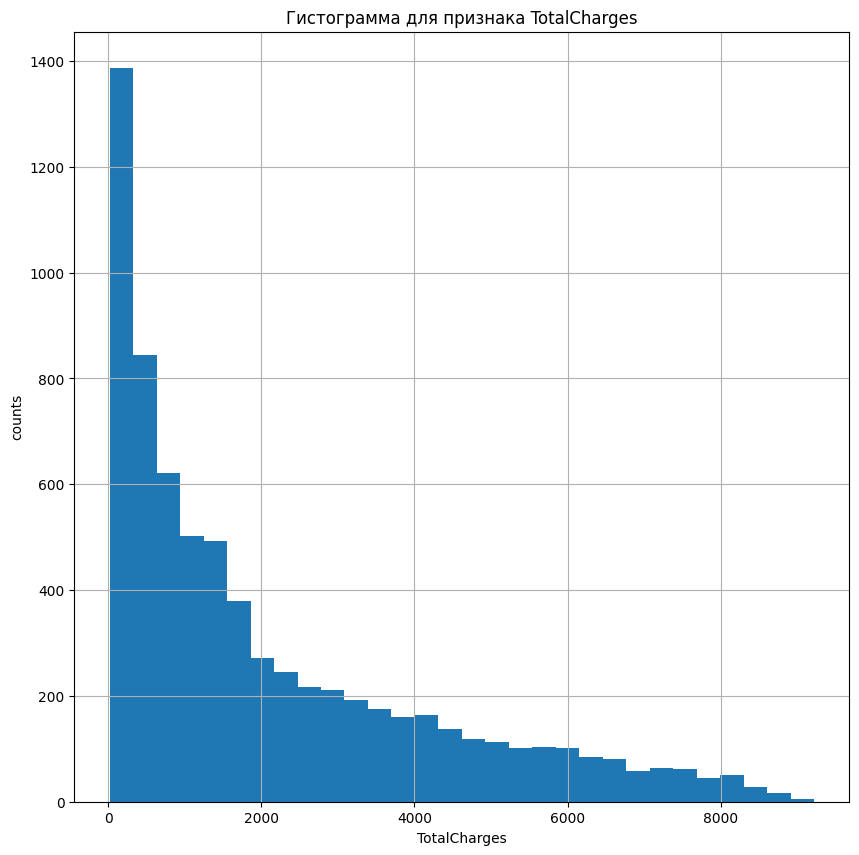

In [76]:
hist(contract_df['TotalCharges'], bins=30)

Больще всего значений в минимуме и равномерный спад. Значения лежат в диапозоне **[19:9922]**. 

Посмотрим на корреляцию `Montly` и `Total` `Charges`.

In [77]:
contract_df['MonthlyCharges'].corr(contract_df['TotalCharges'])

0.6302966354645495

63 % не так много, но и не мало. Не вдаваясь в детали заметим, что `MntlyCharges` более чувствителен как характеристика пользователя, т.к. `Total` все-таки имеет накопительный эффект и при большом backgrounde (пользователи со стажем) может практически не дать нам полезной информации т.к. "звоночки" - могут просто раствориться в большой накопленной сумме. Возьмем только `MontlyCharges`. 

#### Вывод: Информация о договоре

Для будущей модели были отобраны следующие кандидаты: 
- `BeginDate` Данный признак кандидат на передачу будущей модели т.к. от него может зависеть предсказание, например подключения интернета в сентябре могут пргнозировать отключения интернета в июне.. клиенты в этом случае студенты; 
- `Type` Данный признак кандидат для модели т.к. характеризует пользователя;
- `PaymentMethod` Данный признак показывает разницу в распределении значений между дейсвующими и потерянными пользователями; 
- `MonthlyCharges` более чувствителен как характеристика пользователя, т.к. `TotalChanges` все-таки имеет накопительный эффект и при большом backgrounde (пользователи со стажем) может практически не дать нам полезной информации т.к. "звоночки" - могут просто раствориться в большой накопленной сумме.

### Персональные данные клиента

####  `customerID`

In [78]:
contract_df['customerID'].count()

7032

In [79]:
len(set(personal_df['customerID'].unique()) & set(contract_df['customerID'].unique()))

7032

Все юзер ай ди сошлись.

#### `gender`

In [80]:
personal_df['gender'].isna().sum()

0

In [81]:
personal_df['gender'].value_counts(normalize=True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

Мужчин и женщин 50 на 50.

Пока что вснесем этот признак в кандидаты, но дополнительно исследуем после объединения данных.

#### `SeniorCitizen`

In [82]:
personal_df['SeniorCitizen'].isna().sum()

0

In [83]:
personal_df['SeniorCitizen'].value_counts(normalize=True)

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

Пенсионеров 16 %. Аналогично, исследуем подробнее это признак после объединения данных.

#### `Partner`

In [84]:
personal_df['Partner'].isna().sum()

0

In [85]:
personal_df['Partner'].value_counts(normalize=True)

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

Соотношение 50:50. Аналогично предыдущим признакам.

#### `Dependents`

In [86]:
personal_df['Dependents'].isna().sum()

0

In [87]:
personal_df['Dependents'].value_counts(normalize=True)

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64

Дети есть у 30% пользователей. Аналогчино признакам выше, решим после объединения.

#### Вывод: Персональные данные клиента

Все признаки бинарные категории. Решение о том брать или нет отложено на потом.

### Информация об интернет-услугах

#### `InternetService`

In [88]:
internet_df['InternetService'].isna().sum()

0

In [89]:
internet_df['InternetService'].value_counts(normalize=True)

Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

Оптика и DSL распределены 56% и 44% соотвесвенно.

#### `OnlineSecurity`

In [90]:
internet_df['OnlineSecurity'].isna().sum()

0

In [91]:
internet_df['OnlineSecurity'].value_counts(normalize=True)

No     0.63404
Yes    0.36596
Name: OnlineSecurity, dtype: float64

Защищены 37%, а нет 63%.

#### `OnlineBackup`

In [92]:
internet_df['OnlineBackup'].isna().sum()

0

In [93]:
internet_df['OnlineBackup'].value_counts(normalize=True)

No     0.559724
Yes    0.440276
Name: OnlineBackup, dtype: float64

Облачное хранилище у 44% и 56% - нет.

#### `DeviceProtection`

In [94]:
internet_df['DeviceProtection'].isna().sum()

0

In [95]:
internet_df['DeviceProtection'].value_counts(normalize=True)

No     0.560993
Yes    0.439007
Name: DeviceProtection, dtype: float64

#### `TechSupport`

In [96]:
internet_df['TechSupport'].isna().sum()

0

In [97]:
internet_df['TechSupport'].value_counts(normalize=True)

No     0.629509
Yes    0.370491
Name: TechSupport, dtype: float64

#### `StreamingTV`

In [98]:
internet_df['StreamingTV'].isna().sum()

0

In [99]:
internet_df['StreamingTV'].value_counts(normalize=True)

No     0.509335
Yes    0.490665
Name: StreamingTV, dtype: float64

#### `StreamingMovies`

In [100]:
internet_df['StreamingMovies'].isna().sum()

0

In [101]:
internet_df['StreamingMovies'].value_counts(normalize=True)

No     0.504803
Yes    0.495197
Name: StreamingMovies, dtype: float64

#### Вывод: Информация об интернет услугах

Все признаки имеют по два значения - по шаблону да/нет. Брать их или нет - решим позже.

### Информация об услугах телефонии

#### `MultipleLines`

In [102]:
phone_df['MultipleLines'].isna().sum()

0

In [103]:
phone_df['MultipleLines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: MultipleLines, dtype: float64

#### Вывод: Информация об услугах телефонии

Так же бинарный признак. 53 и 47 % - нет и да. Решение по нему позже.

## Объединение данных в один датафрейм по ключу

### Объединение

Перед объединением добавим признаки, которые покажут пользуется ли пользователь интернетом, телефоном или и тем и другим.

In [104]:
internet_df['internet'] = 1

In [105]:
phone_df['phone'] = 1

In [106]:
contract_df.shape

(7032, 8)

In [107]:
df = contract_df.merge(personal_df, on='customerID', how='outer')

In [108]:
df.shape

(7043, 12)

In [109]:
df = df.merge(internet_df, on='customerID', how='outer')

In [110]:
df.shape

(7043, 20)

In [111]:
df = df.merge(phone_df, on='customerID', how='outer')

In [112]:
df.shape

(7043, 22)

In [113]:
df.sample(n=5, random_state=RANDOM_STATE)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone
15,3655-SNQYZ,2014-05-01,2016-03-01,Two year,No,Credit card (automatic),113.25,2491.50,Female,0,...,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,1.0,Yes,1.0
1329,0121-SNYRK,2015-12-01,2020-02-01,One year,Yes,Mailed check,35.40,1947.00,Male,0,...,DSL,Yes,No,No,Yes,No,No,1.0,NaN,NaN
52,6575-SUVOI,2018-01-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),69.50,1807.00,Female,1,...,DSL,Yes,No,No,Yes,Yes,No,1.0,Yes,1.0
2957,3237-AJGEH,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,31.00,132.68,Female,0,...,DSL,No,No,No,Yes,No,No,1.0,NaN,NaN
1362,4238-HFHSN,2015-01-01,2020-02-01,Month-to-month,Yes,Electronic check,82.15,5011.15,Male,1,...,Fiber optic,No,Yes,No,No,No,No,1.0,Yes,1.0


### Обработка пропусков

In [114]:
df.isna().sum()

customerID             0
BeginDate             11
EndDate               11
Type                  11
PaperlessBilling      11
PaymentMethod         11
MonthlyCharges        11
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
internet            1526
MultipleLines        682
phone                682
dtype: int64

В тех признаках, где пропусков по 11 - проверим не те ли это пользоатели, которых мы удалили когда выснили что они только сегодня к нам присоединились.

In [115]:
(df[df['BeginDate'].isna()]['customerID'].reset_index(drop=True) == 
mem_cutomer_id_with_empty_total_charges.reset_index(drop=True)).sum()

11

Полное число совпадений! Исключим из датафрейма все строки, где `BeginDate` пропущено!

In [116]:
df = df[~df['BeginDate'].isna()]

In [117]:
df.shape

(7032, 22)

In [118]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
internet            1520
MultipleLines        680
phone                680
dtype: int64

Остались пропуски только в тех данных, которые храктеризуют дополнительные услуги. Посмотрим на них и заполним значениями - не используется, но в соотвесвии с общим шаблоном для конктретного признака.

In [119]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2416
Name: InternetService, dtype: int64

In [120]:
df['InternetService'] = df['InternetService'].fillna('not used')

In [121]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2416
not used       1520
Name: InternetService, dtype: int64

In [122]:
df['OnlineSecurity'].value_counts()

No     3497
Yes    2015
Name: OnlineSecurity, dtype: int64

In [123]:
df['OnlineSecurity'] = df['OnlineSecurity'].fillna('No')

In [124]:
df['OnlineSecurity'].value_counts()

No     5017
Yes    2015
Name: OnlineSecurity, dtype: int64

In [125]:
df['OnlineBackup'].value_counts()

No     3087
Yes    2425
Name: OnlineBackup, dtype: int64

In [126]:
df['OnlineBackup'] = df['OnlineBackup'].fillna('No')

In [127]:
df['OnlineBackup'].value_counts()

No     4607
Yes    2425
Name: OnlineBackup, dtype: int64

In [128]:
df['DeviceProtection'].value_counts()

No     3094
Yes    2418
Name: DeviceProtection, dtype: int64

In [129]:
df['DeviceProtection'] = df['DeviceProtection'].fillna('No')

In [130]:
df['DeviceProtection'].value_counts()

No     4614
Yes    2418
Name: DeviceProtection, dtype: int64

In [131]:
df['TechSupport'].value_counts()

No     3472
Yes    2040
Name: TechSupport, dtype: int64

In [132]:
df['TechSupport'] = df['TechSupport'].fillna('No')

In [133]:
df['TechSupport'].value_counts()

No     4992
Yes    2040
Name: TechSupport, dtype: int64

In [134]:
df['StreamingTV'].value_counts()

No     2809
Yes    2703
Name: StreamingTV, dtype: int64

In [135]:
df['StreamingTV'] = df['StreamingTV'].fillna('No')

In [136]:
df['StreamingTV'].value_counts()

No     4329
Yes    2703
Name: StreamingTV, dtype: int64

In [137]:
df['StreamingMovies'].value_counts()

No     2781
Yes    2731
Name: StreamingMovies, dtype: int64

In [138]:
df['StreamingMovies'] = df['StreamingMovies'].fillna('No')

In [139]:
df['StreamingMovies'].value_counts()

No     4301
Yes    2731
Name: StreamingMovies, dtype: int64

In [140]:
df['internet'] = df['internet'].fillna(0)

In [141]:
df['internet'].value_counts()

1.0    5512
0.0    1520
Name: internet, dtype: int64

In [142]:
df['MultipleLines'].value_counts()

No     3385
Yes    2967
Name: MultipleLines, dtype: int64

In [143]:
df['MultipleLines'] = df['MultipleLines'].fillna('No')

In [144]:
df['MultipleLines'].value_counts()

No     4065
Yes    2967
Name: MultipleLines, dtype: int64

In [145]:
df['phone'] = df['phone'].fillna(0)

In [146]:
df['phone'].value_counts()

1.0    6352
0.0     680
Name: phone, dtype: int64

In [147]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
internet            0
MultipleLines       0
phone               0
dtype: int64

## Исследовательский анализ и предобработка данных объединённого датафрейма

### `gender`

In [148]:
compare(df, 'gender')

Распределение занчений в общем:
Male      0.504693
Female    0.495307
Name: gender, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
Male      0.50177
Female    0.49823
Name: gender, dtype: float64

Распрделение значений в группе ушедших пользователей:
Male      0.520436
Female    0.479564
Name: gender, dtype: float64


Распределения долей - довольно близкие! Этот признак не подходит!

### `SeniorCitizen`

In [149]:
compare(df, 'SeniorCitizen')

Распределение занчений в общем:
0    0.8376
1    0.1624
Name: SeniorCitizen, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
0    0.846569
1    0.153431
Name: SeniorCitizen, dtype: float64

Распрделение значений в группе ушедших пользователей:
0    0.789282
1    0.210718
Name: SeniorCitizen, dtype: float64


Распределение отличаются примрно на 5%, а это не очень сущесвенно при маленькой выборке. Посммотрим на пенсионеров поближе. Проверим гипотезу, что они пользуются толко телефоном.

In [150]:
df[df['SeniorCitizen'] == 1]['customerID'].count()

1142

In [151]:
df[(df['SeniorCitizen'] == 1) & (df['phone'] == 1) & (df['internet'] == 0)]['customerID'].count()

52

Гипотеза не оправдалсь!  Таких пенсионера всего 52. Но все-таки отбросим этот признак.

### `Partner` 

In [152]:
compare(df, 'Partner')

Распределение занчений в общем:
No     0.517491
Yes    0.482509
Name: Partner, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
No     0.549149
Yes    0.450851
Name: Partner, dtype: float64

Распрделение значений в группе ушедших пользователей:
Yes    0.653043
No     0.346957
Name: Partner, dtype: float64


Тут различия сущесвены. Берем этот признак.

### `Dependents`

In [153]:
compare(df, 'Dependents')

Распределение занчений в общем:
No     0.701507
Yes    0.298493
Name: Dependents, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
No     0.708144
Yes    0.291856
Name: Dependents, dtype: float64

Распрделение значений в группе ушедших пользователей:
No     0.665758
Yes    0.334242
Name: Dependents, dtype: float64


Все те же 5% - не берем.

### `InternetService`

In [154]:
compare(df, 'InternetService')

Распределение занчений в общем:
Fiber optic    0.440273
DSL            0.343572
not used       0.216155
Name: InternetService, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
Fiber optic    0.421683
DSL            0.349014
not used       0.229304
Name: InternetService, dtype: float64

Распрделение значений в группе ушедших пользователей:
Fiber optic    0.540418
DSL            0.314260
not used       0.145322
Name: InternetService, dtype: float64


Тут различия ощутимы.Берем этот признак.

### `OnlineSecurity`

In [155]:
compare(df, 'OnlineSecurity')

Распределение занчений в общем:
No     0.713453
Yes    0.286547
Name: OnlineSecurity, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
No     0.730231
Yes    0.269769
Name: OnlineSecurity, dtype: float64

Распрделение значений в группе ушедших пользователей:
No     0.62307
Yes    0.37693
Name: OnlineSecurity, dtype: float64


Тут так же ощутимая разница -берем.

### `OnlineBackup`

In [156]:
compare(df,'OnlineBackup')

Распределение занчений в общем:
No     0.655148
Yes    0.344852
Name: OnlineBackup, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
No     0.68555
Yes    0.31445
Name: OnlineBackup, dtype: float64

Распрделение значений в группе ушедших пользователей:
Yes    0.508629
No     0.491371
Name: OnlineBackup, dtype: float64


Тут то же разница ощутима - берем!

### `DeviceProtection`

In [157]:
compare(df, 'DeviceProtection')

Распределение занчений в общем:
No     0.656143
Yes    0.343857
Name: DeviceProtection, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
No     0.685045
Yes    0.314955
Name: DeviceProtection, dtype: float64

Распрделение значений в группе ушедших пользователей:
No     0.500454
Yes    0.499546
Name: DeviceProtection, dtype: float64


Берем!

### `TechSupport`

In [158]:
compare(df, 'TechSupport')

Распределение занчений в общем:
No     0.709898
Yes    0.290102
Name: TechSupport, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
No     0.72315
Yes    0.27685
Name: TechSupport, dtype: float64

Распрделение значений в группе ушедших пользователей:
No     0.63851
Yes    0.36149
Name: TechSupport, dtype: float64


Берем!

### `StreamingTV`

In [159]:
compare(df, 'StreamingTV')

Распределение занчений в общем:
No     0.615614
Yes    0.384386
Name: StreamingTV, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
No     0.642725
Yes    0.357275
Name: StreamingTV, dtype: float64

Распрделение значений в группе ушедших пользователей:
Yes    0.530427
No     0.469573
Name: StreamingTV, dtype: float64


Берем!

### `StreamingMovies`

In [160]:
compare(df, 'StreamingMovies')

Распределение занчений в общем:
No     0.611633
Yes    0.388367
Name: StreamingMovies, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
No     0.641713
Yes    0.358287
Name: StreamingMovies, dtype: float64

Распрделение значений в группе ушедших пользователей:
Yes    0.550409
No     0.449591
Name: StreamingMovies, dtype: float64


Берем!

### `MultipleLines`

In [161]:
compare(df, 'MultipleLines')

Распределение занчений в общем:
No     0.578072
Yes    0.421928
Name: MultipleLines, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
No     0.614062
Yes    0.385938
Name: MultipleLines, dtype: float64

Распрделение значений в группе ушедших пользователей:
Yes    0.615804
No     0.384196
Name: MultipleLines, dtype: float64


Тут разница не сущесвенна, не берем его!

### `internet`

In [162]:
compare(df, 'internet')

Распределение занчений в общем:
1.0    0.783845
0.0    0.216155
Name: internet, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
1.0    0.770696
0.0    0.229304
Name: internet, dtype: float64

Распрделение значений в группе ушедших пользователей:
1.0    0.854678
0.0    0.145322
Name: internet, dtype: float64


Распределение для тех, кото ушел выделяется! оставим его!

### `phone`

In [163]:
compare(df, 'phone')

Распределение занчений в общем:
1.0    0.903299
0.0    0.096701
Name: phone, dtype: float64

Распрделение значений в группе дейсвующих пользователей:
1.0    0.902715
0.0    0.097285
Name: phone, dtype: float64

Распрделение значений в группе ушедших пользователей:
1.0    0.906449
0.0    0.093551
Name: phone, dtype: float64


Разница минимальна. Убераем его!

### Вывод: Исследовательский анализ и предобработка данных объединённого датафрейма

В итоге, посмотрем как рапределены значения категориальных признаков в группах дейвующих и ушедших пользователей, мы оторбрали для будущей модели следующие признаки:
- `InternetService`
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`

## Список призаков - кандидатов для модели

- `BeginDate`
- `Type`
- `PaymentMethod`
- `MonthlyCharges`
- `Partner`
- `InternetService`
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`

## Подготовка данных

### добавление признака  `days`

Перед тем как готовить данные, сформируем признак `days`, который будет хранить число дней которые прошли с момента заключения договора. Этот признак позволит нам харкатеризовать пользователей максимально актуально на тукущий момент. Возьмем его для модели вместо `BeginDate` т.к. `BeginDate` - все-таки обусловлен случайностью, а не закономерностью. 

In [164]:
df['days'] = (df['EndDate'] - df['BeginDate']).dt.days

In [165]:
df['days'].describe()

count    7032.000000
mean      899.961320
std       682.738777
min        28.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: days, dtype: float64

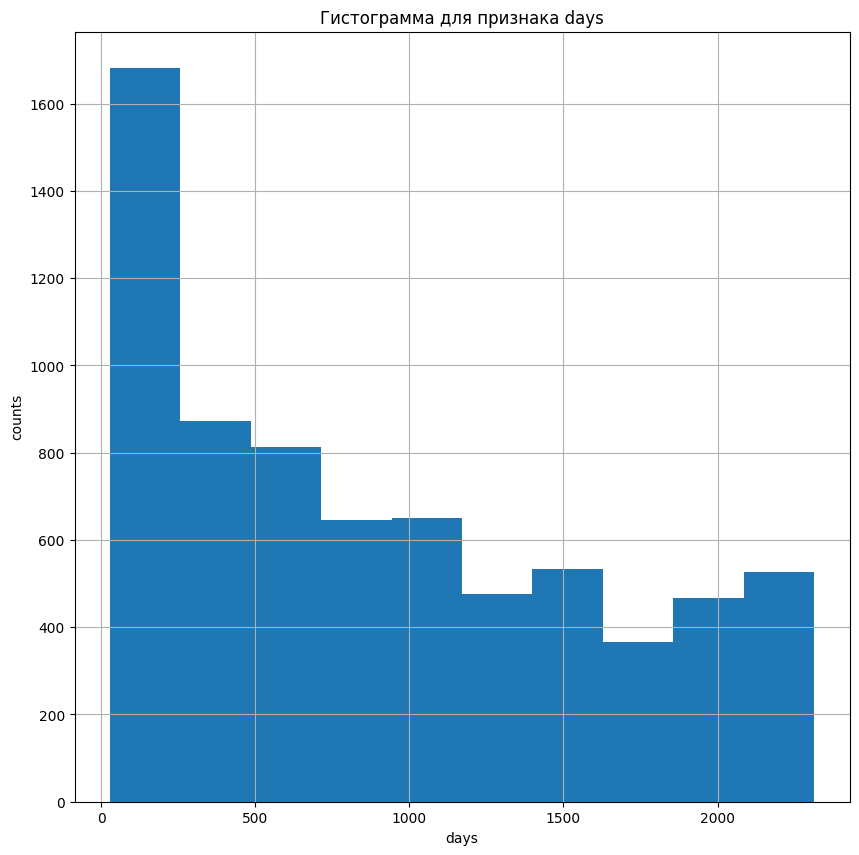

In [166]:
hist(df['days'])

Больше всего пользователей с минимаьным стажем, дальше идет равномерный спад. 

### формирование features и target 

Из отобранных признаков сформируем features, а из `EndDate` сформруем target.

In [167]:
df['target'] = 0 # дейсвующие пользователи

In [168]:
df.loc[df['EndDate'] != '2020-02-01', 'target'] = 1 # ушедшие пользователи

In [169]:
df[df['EndDate'] == '2020-02-01']['EndDate'].count() / df['EndDate'].count()

0.8434300341296929

In [170]:
df['target'].value_counts(normalize=True)

0    0.84343
1    0.15657
Name: target, dtype: float64

In [171]:
features_names_list = ['days', 'Type', 'PaymentMethod', 'MonthlyCharges', 'Partner', 
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
features = df[features_names_list]

Список отобранных признаков.

- `days`
- `Type`
- `PaymentMethod`
- `MonthlyCharges`
- `Partner`
- `InternetService`
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`

In [172]:
features.head()

,days,Type,PaymentMethod,MonthlyCharges,Partner,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,31,Month-to-month,Electronic check,29.85,Yes,DSL,No,Yes,No,No,No,No
1,1036,One year,Mailed check,56.95,No,DSL,Yes,No,Yes,No,No,No
2,123,Month-to-month,Mailed check,53.85,No,DSL,Yes,Yes,No,No,No,No
3,1371,One year,Bank transfer (automatic),42.30,No,DSL,Yes,No,Yes,Yes,No,No
4,153,Month-to-month,Electronic check,70.70,No,Fiber optic,No,No,No,No,No,No


In [173]:
target = df['target']

In [174]:
features.shape

(7032, 12)

In [175]:
target.shape

(7032,)

### анализ корреляций

In [176]:
cat_features_names_list = features_names_list.copy()
cat_features_names_list.remove('days')
cat_features_names_list.remove('MonthlyCharges')
cat_features_names_list

['Type',
 'PaymentMethod',
 'Partner',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

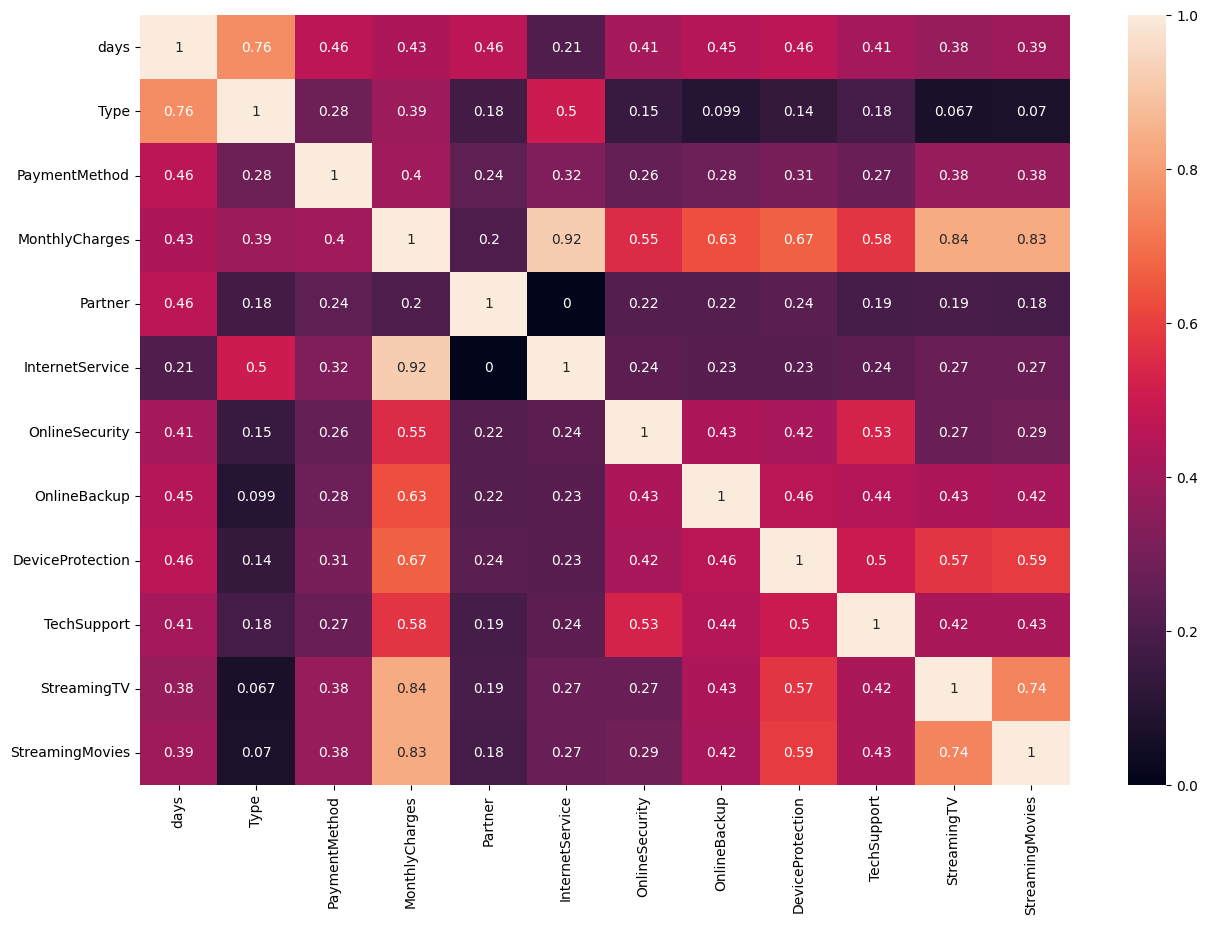

In [177]:
plt.subplots(figsize=(15, 10))

sns.heatmap(features.phik_matrix(interval_cols=['MonthlyCharges']), annot=True);

Сразу бросается в глаза, что `MonthlyCharges` скоррелирован со многими признаками.. избавимся от него. Так же `StreamingTV` и `StreamingMivies` скоррелятрованы достаточно сильно - оставим из них `StreamingTV`. `days` и `Type` тоже скорреляированы - удалим `Type`.

In [178]:
features = features.drop(['Type', 'MonthlyCharges', 'StreamingMovies'], axis=1)

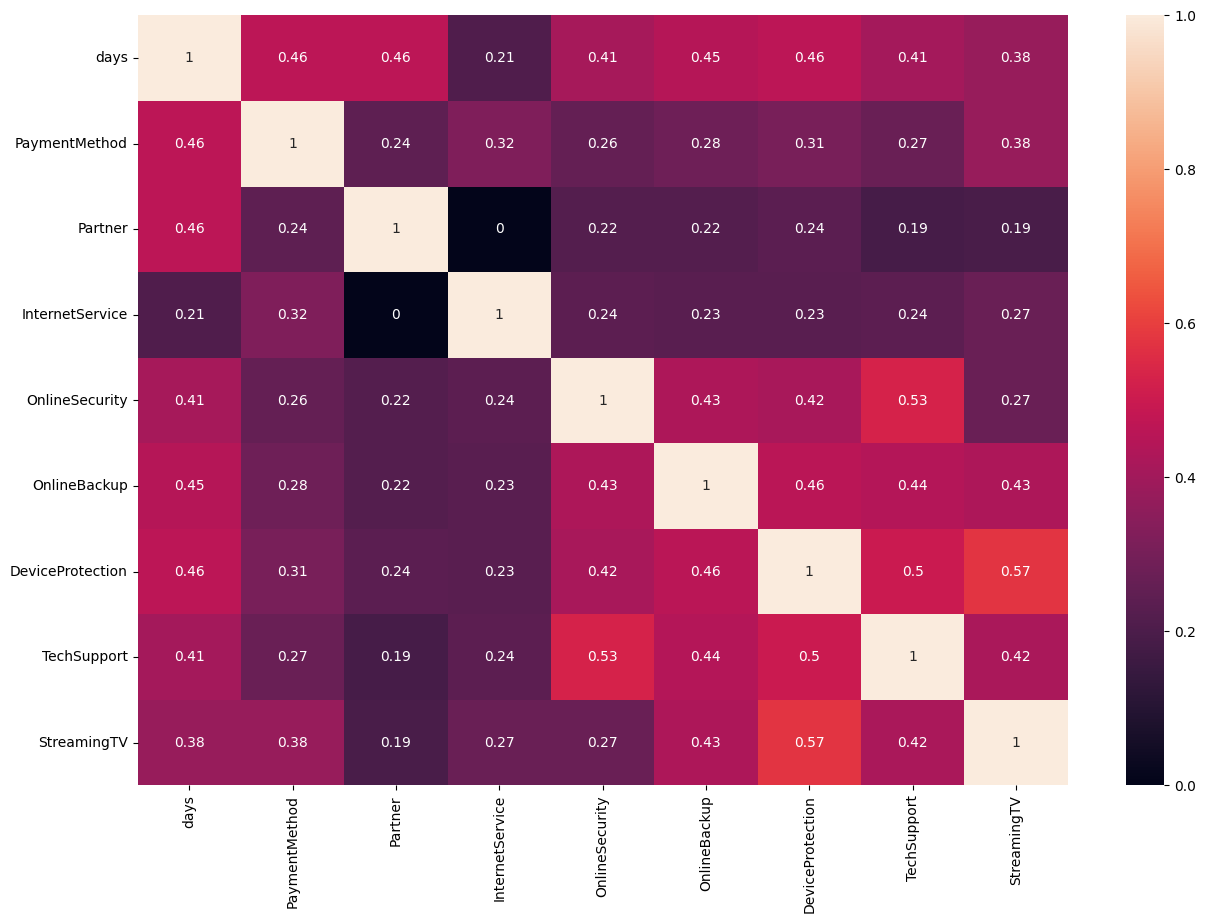

In [179]:
plt.subplots(figsize=(15, 10))

sns.heatmap(features.phik_matrix(interval_cols=['MonthlyCharges']), annot=True);

Корреляции не сильно выражены. 

#### Вывод: анализ корреляций

В результате анализа корреляций были отброшены `Type`, `MonthlyCharges`, `StreamingMovies`. 
В итоге для модели были окончательно тобораны:

- `days`
- `PaymentMethod`
- `Partner`
- `InternetService`
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`

## Разделение на обучающую и тестовую выборки

In [180]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [181]:
features_train.shape

(5274, 9)

In [182]:
target_train.shape

(5274,)

In [183]:
features_test.shape

(1758, 9)

In [184]:
target_test.shape

(1758,)

## Обучение моделей

In [185]:
numerical_cols = ['days']

In [186]:
categorical_cols = features.drop(['days'], axis=1).columns.to_list()
categorical_cols

['PaymentMethod',
 'Partner',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV']

In [187]:
# Препроцесинг для численых данных
numerical_transformer = StandardScaler()

# Препроцесинг для категориальных данных
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Объедининие процессов 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### LogisticRegression

In [188]:
logistic_reg_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_STATE)

In [189]:
pipeline = Pipeline(steps=[('pre_processing', preprocessor),
                            ('model', logistic_reg_model)
                             ])

In [190]:
C = [0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']

In [191]:
parameters = {
    "model__C": C,
    "model__penalty": penalty
}

In [192]:
clf_log_reg_GS = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=5)

In [193]:
clf_log_reg_GS.fit(features_train, target_train);

In [194]:
print("Best score (roc_auc=%0.3f):" % clf_log_reg_GS.best_score_)
print(clf_log_reg_GS.best_params_)

Best score (roc_auc=0.713):
{'model__C': 100, 'model__penalty': 'l1'}


#### Вывод: LogisticRegression

Линейная модель дала результат на кросс валидации: **0.713**

### RandomForestClassifier

In [195]:
# Препроцесинг для категориальных данных
categorical_transformer = OrdinalEncoder()

# Объедининие процессов 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [196]:
rnd_forest_model = RandomForestClassifier(random_state=RANDOM_STATE)

In [197]:
pipeline = Pipeline(steps=[('pre_processing', preprocessor),
                            ('model', rnd_forest_model)
                             ])

In [198]:
n_est = [10, 20, 100, 200]
max_depth = [2, 5, 10, 100, 200]
criterion = ['gini', 'entropy']

In [199]:
parameters = {
    "model__n_estimators": n_est,
    "model__max_depth": max_depth,
    "model__criterion": criterion
}

In [200]:
clf_rnd_forest_GS = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=5)

In [201]:
%%time

clf_rnd_forest_GS.fit(features_train, target_train);

CPU times: user 36.7 s, sys: 27.8 ms, total: 36.7 s
Wall time: 36.7 s


In [202]:
print("Best score (roc_auc=%0.3f):" % clf_rnd_forest_GS.best_score_)
print(clf_rnd_forest_GS.best_params_)

Best score (roc_auc=0.806):
{'model__criterion': 'entropy', 'model__max_depth': 10, 'model__n_estimators': 200}


#### Вывод: RandomForestClassifier

На кросс-валидации RandomForest показал roc-auc=**0.8**. Не плохо, но это не то что нам нужно.

### CatBoostClassifier

Для CatBoost кодирование не требуется, поэтому мы не будем делать кодирование и масштабирование.

In [203]:
cat_boost_model = CatBoostClassifier(cat_features=categorical_cols,
                                     verbose=False, random_state=RANDOM_STATE)

In [204]:
parameters = {
    "iterations": [5, 10, 50, 100, 200, 300],
    "learning_rate": [1., 0.1, 0.01],
}

In [205]:
clf_cat_boost_GS = GridSearchCV(cat_boost_model, parameters, scoring='roc_auc', cv=5)

In [ ]:
%%time

clf_cat_boost_GS.fit(features_train, target_train);

In [ ]:
print("Best score (roc_auc=%0.3f):" % clf_cat_boost_GS.best_score_)
print(clf_cat_boost_GS.best_params_)

#### Вывод: CatBoostClassifier

CatBoostClassifier показал себя с лушей стороны. 
С параметрами:
- iterations=300
- learning_rate=0.1

Модель выдала roc_auc=0.919 на кросс-влидации.

Это наша лучшая модель!

## Тестирование лучшей модели

In [ ]:
roc_auc_score(target_test, clf_cat_boost_GS.predict_proba(features_test)[:, 1])

In [ ]:
draw_roc_curve(target_test, clf_cat_boost_GS.predict_proba(features_test)[:, 1],
               title='ROC-кривая CatBoostClassifier на тестовой выборке')

### Вывод: Тестирование лучшей модели

На тестовой выборке лучшая модель дала результат:

**roc_auc=0.92**

## Отчет

В данной работе нам нужно было построить прототип модели машинного обучения для компании предоставляющей интернет и телефонные услуги. Модель должна предсказывать - растрогнет ли пользователь договор или нет. 

Требуемая точность модели определяется **ROC-AUC >= 0.85**

Было расмотрено 3 модели машинного обучения, среди них лучшей оказалась модель:

**CatBoostClassifier** со следующими гиперпараметрами:
- **iterations=300**
- **learning_rate=0.1**

Она показала следующий результат на **тестовой выборке**: **ROC-AUC=0.92**

**Информация о данных и признаках**:
- Данные содержать информацию о 7043 пользователях.Из них пользуются:
    - интернетом и телефоном 4835;
    - только интеретом 682;
    - только телефоном 1526;

- Данные не содержат явных пропусков и дубликатов. 

- Было выявлено 11 пользователей, которые только заключили договор - они были удалены т.к. не несут полезной информации в рамках нашей задачи.

- Из всех доступных признаков для обучения было отобрано 9 (из них 1 численный - `days`, а остальные категориальные):
    - `days`- количество дней, которые прошли с момента заключения договора:
        - был сформирован как разница в дате заключения договра и момента актуализации данных (или расторжения договора);
        - был отобран так как характеризует пользователя в динамике и существенно не скореллирован с другими признаками. 
    - тип платежа:
    - есть ли у абонента супруг или супруга;
    - тип подключения;
    - блокировка опасных сайтов;
    - облачное хранилище файлов для резервного копирования данных;
    - антивирус;
    - выделенная линия технической поддержки;
    - триминговое телевидение;
    - все категориальные признаки были отобраны т.к. показали существенную разницу в распределений значений в разных группах: дейсвующих дговорах и расторгнутых; а так же не существенно скореллированы с другими призаками;
    - изначально, данные находились в разных файлах и были объденены по ключу, после этого в некоторых категориях появились пропуски. Эти пропуски появились только в категориальных признаках и в тех местах, где клиент не использовал услугу. Следовательно, пропуски были заполнены значениями, которые соотвевует "не использует", но для каждого признака согласно выделенному под этот смысл значению.  